## Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve, validation_curve, GridSearchCV, cross_val_score
from sklearn.linear_model import Lasso, LassoCV, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Import data

In [2]:
# Path to the CSV file
csv_path = 'data/merged_data.csv'

# Read the CSV file into a DataFrame
merged_data = pd.read_csv(csv_path)

## Adding variables

Here we also log-transform the sqmPrice in order to reduce the subsequent MSE

We also add a variable 'distance_from_centre' which is the gaussian distance from 'Rådhuspladsen' in Copenhagen

In [3]:
merged_data['sqmPrice'] = np.log(merged_data['sqmPrice'])
copenhagen_centre_latitude = 55.675902629
copenhagen_centre_longitude = 12.568809986
merged_data['distance_from_centre'] = np.sqrt((merged_data['longitude']-copenhagen_centre_longitude)**2 + (merged_data['latitude']-copenhagen_centre_latitude)**2)

## Dropping Rows

Here we remove the 3 highest sqm price municipalities: Fredensborg, Rudersdal and Furesø

In [4]:
merged_data = merged_data[~merged_data['Municipality'].isin(['Fredensborg', 'Rudersdal', 'Furesø'])]

In [5]:
merged_data['Municipality'].unique()

array(['Guldborgsund', 'Lolland', 'Lejre', 'Vordingborg', 'Gribskov',
       'Halsnæs', 'Odsherred', 'Frederikssund', 'Kalundborg', 'Bornholm',
       'Næstved', 'Slagelse', 'Egedal', 'Faxe', 'Helsingør', 'Stevns',
       'Roskilde', 'Holbæk', 'Hillerød', 'Allerød', 'Sorø', 'Ringsted',
       'Køge'], dtype=object)

## Dropping columns

We drop columns which doesn't make sense to have in the model (city, estateCode etc.)

In [6]:
# List of columns to drop
columns_to_drop = [
    'saleType', 'guid', 'latitude', 'longitude',
    'estateCode', 'city', 'groupKey', 'canGetVR', 'bfEnr'
]

# Dropping the columns from the DataFrame
data = merged_data.drop(columns=columns_to_drop)

In [7]:
data.sample(5)

,estateId,address,zipCode,price,soldDate,propertyType,sqmPrice,rooms,size,buildYear,...,gini_coefficient,average_age,immigrants,municipal_tax,primaryschool,kvu,lvu,job,population,distance_from_centre
23477,1520835,Stranddalen 22,4571,825000,2020-06-20 22:00:00+00:00,4,9.433484,3,66,1973,...,23.78,48.8,0.070064,26.6,0.328969,0.036698,0.035994,0.580271,21309,0.966950
6406,0,Slåenvangen 35,3120,714000,2023-12-04 23:00:00+00:00,4,9.671976,3,45,1969,...,27.38,47.7,0.101589,25.4,0.246742,0.052497,0.074242,0.537377,27316,0.479553
35288,1303506,Svanebakken 1,3740,2400000,2018-01-21 23:00:00+00:00,4,9.937389,6,116,2001,...,23.96,47.9,0.075044,26.2,0.312620,0.035991,0.040240,0.700283,26118,2.630748
1391,1825333,Torilisvej 28,4873,1500000,2021-09-29 22:00:00+00:00,4,9.944310,4,72,1979,...,25.59,46.8,0.086157,25.8,0.306173,0.041746,0.039082,0.645949,39788,1.199956
17861,1769289,Risengen 11,4480,995000,2021-04-17 22:00:00+00:00,4,9.576392,4,69,1974,...,24.91,45.4,0.074548,24.4,0.318025,0.048763,0.037135,0.650700,32422,1.402461


## Heatmap

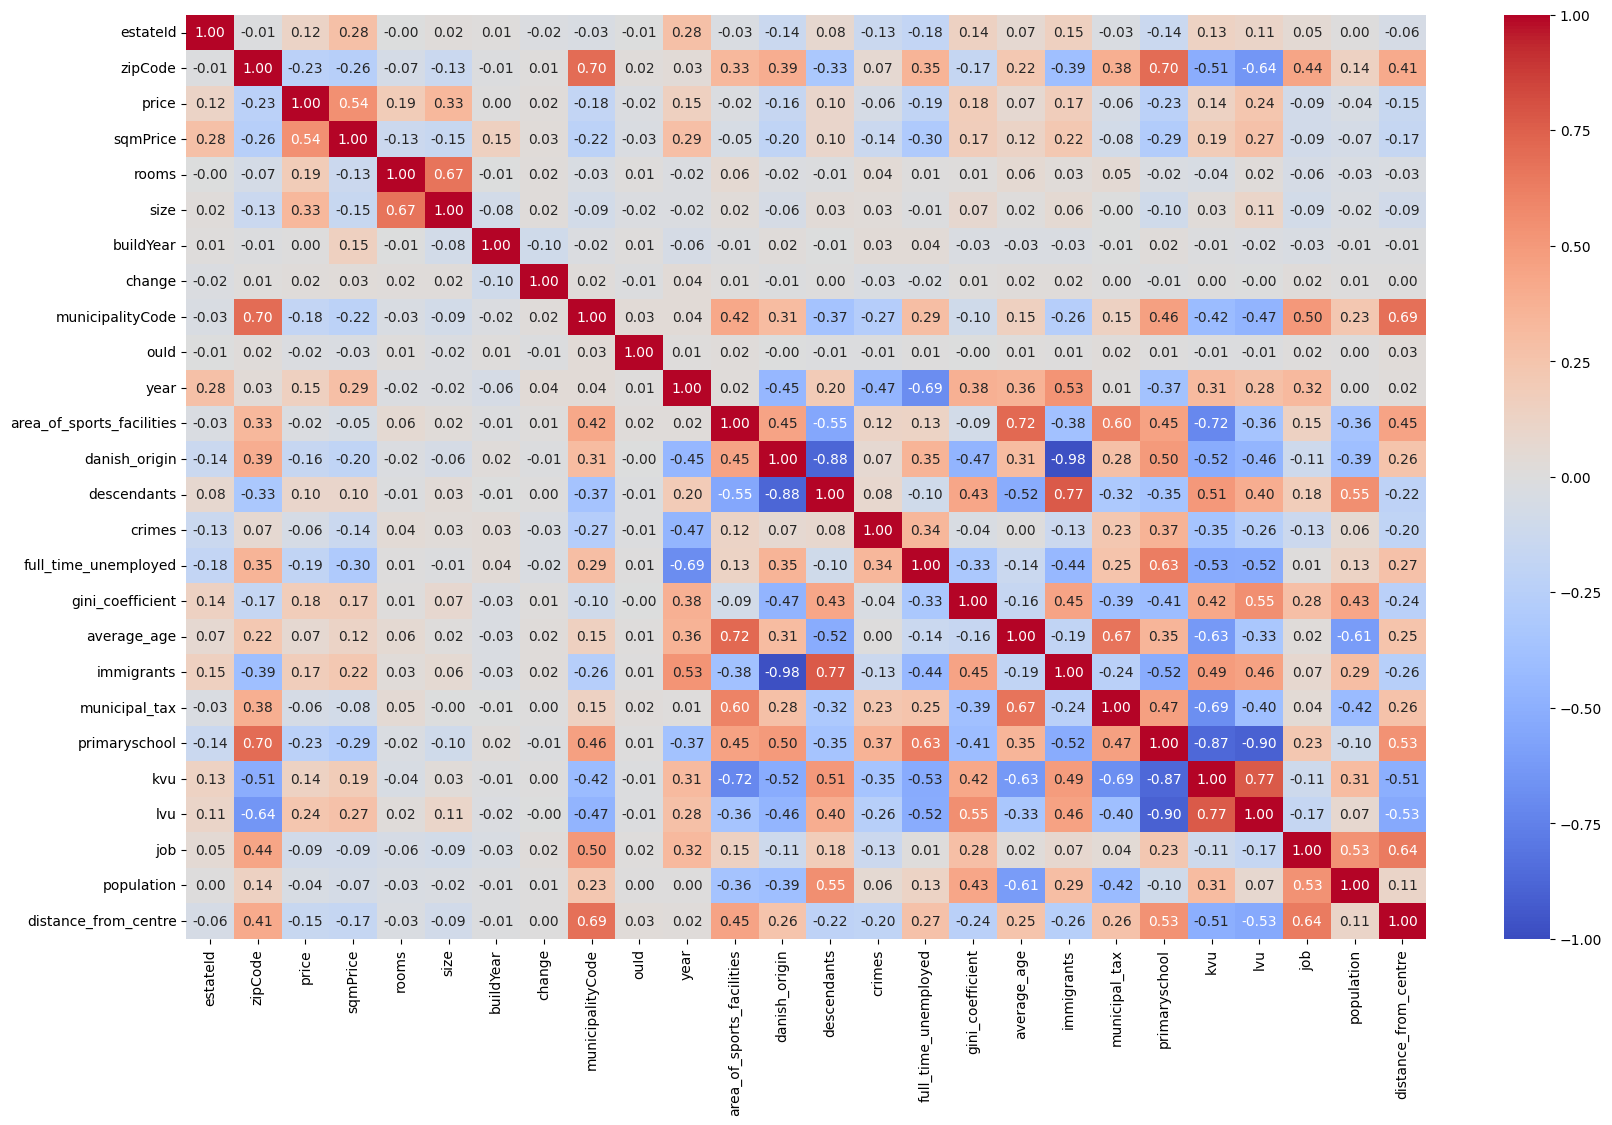

In [8]:
# Removing all non-integer variables
X_df = data.drop(['address', 'soldDate', 'ouAddress', 'Municipality', 'propertyType'], axis=1)

# Creating correlation heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(X_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.show()

## Define split data function

In [9]:
def split_data(X, y):
    # Remove rows with NaN values from both X and y
    mask = ~(X.isna().any(axis=1) | y.isna())
    X = X[mask]
    y = y[mask]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99999)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Handle potential negative or zero values in y
    y_train_pos = y_train[y_train > 0]
    y_test_pos = y_test[y_test > 0]

    y_train_log = np.log(y_train_pos)
    y_test_log = np.log(y_test_pos)
    
    return X_train_scaled, X_test_scaled, y_train_log, y_test_log

# Lasso regression

## Fitting lasso
Here we select our initial explanatory variables, and set the dependent variable

In [10]:
X = data.drop(['propertyType','sqmPrice', 'municipalityCode', 'estateId', 'address', 'zipCode', 'price', 'soldDate', 'ouId', 'ouAddress', 'change', 'Municipality', 'population','danish_origin'], axis=1)
y = data['sqmPrice']
X_train, X_test, y_train, y_test = split_data(X, y)

In [11]:
lasso_model = Lasso(alpha=0.000115) 
lasso_model.fit(X_train, y_train)
y_pred= lasso_model.predict(X_test)

mse_log = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse_log.round(4)}")

lasso_coeff= pd.Series(lasso_model.coef_, index= X.columns)
lasso_coeff

MSE: 0.005


rooms                       -0.004029
size                        -0.011639
buildYear                    0.012258
year                         0.010790
area_of_sports_facilities   -0.003979
descendants                  0.016440
crimes                      -0.000779
full_time_unemployed        -0.000266
gini_coefficient            -0.000152
average_age                  0.025490
immigrants                  -0.007062
municipal_tax               -0.015030
primaryschool               -0.023679
kvu                         -0.017896
lvu                          0.008450
job                         -0.008244
distance_from_centre        -0.000483
dtype: float64

## Removal of insignificant variables - Lasso Regression

In [12]:
significant_indices = np.where(np.abs(lasso_coeff) > 1e-3)[0]
X_train_selected = X_train[:, significant_indices]
X_test_selected = X_test[:, significant_indices]

In [13]:
lasso_model = Lasso(alpha=0.00015)
lasso_model.fit(X_train_selected, y_train)
y_pred_log = lasso_model.predict(X_test_selected)
mse_log = mean_squared_error(y_test, y_pred_log)
print(f"MSE: {mse_log.round(4)}")
lasso_coef = pd.Series(lasso_model.coef_, index= X.columns[significant_indices])
lasso_coef

MSE: 0.005


rooms                       -0.003999
size                        -0.011618
buildYear                    0.012209
year                         0.010300
area_of_sports_facilities   -0.003821
descendants                  0.015232
average_age                  0.026024
immigrants                  -0.005990
municipal_tax               -0.014626
primaryschool               -0.022403
kvu                         -0.015258
lvu                          0.008557
job                         -0.008187
dtype: float64

## Validation - Lasso Regression

In [14]:
max_degree = 5
n_lambdas = 12

degree_range = range(max_degree)
lambdas = np.logspace(-4, 4, n_lambdas)

mse_results = []

for degree in degree_range:
    models = [
        make_pipeline(
            PolynomialFeatures(degree=degree),
            StandardScaler(),
            Lasso(alpha=lambda_, random_state=99999, max_iter=2000, tol=0.01)
        )
        for lambda_ in lambdas
    ]
    
    mse_scores = [
        mean_squared_error(y_test, model.fit(X_train_selected, y_train).predict(X_test_selected))
        for model in models
    ]
    
    best_idx = np.argmin(mse_scores)
    optimal_lambda = lambdas[best_idx]
    optimal_mse = mse_scores[best_idx]
    
    mse_results.append(optimal_mse)
    print(f"Degree: {degree}, Optimal lambda: {optimal_lambda:.4f}, Validation MSE: {optimal_mse:.4f}")

Degree: 0, Optimal lambda: 0.0001, Validation MSE: 0.0066
Degree: 1, Optimal lambda: 0.0001, Validation MSE: 0.0050
Degree: 2, Optimal lambda: 0.0001, Validation MSE: 0.0047
Degree: 3, Optimal lambda: 0.0001, Validation MSE: 0.0045
Degree: 4, Optimal lambda: 0.0001, Validation MSE: 0.0045


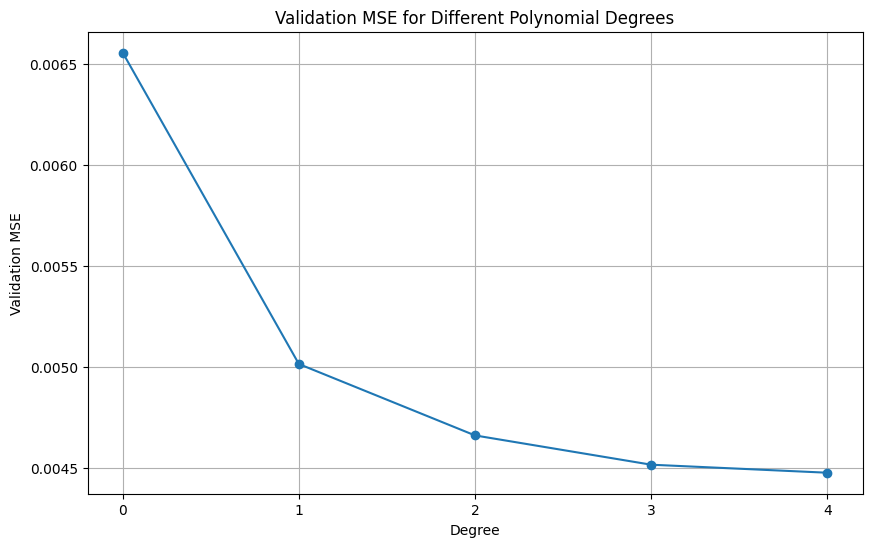

In [15]:
# Plot the MSE values against the degrees
plt.figure(figsize=(10, 6))
plt.plot(degree_range, mse_results, marker='o')
plt.xlabel('Degree')
plt.ylabel('Validation MSE')
plt.title('Validation MSE for Different Polynomial Degrees')
plt.xticks(degree_range)
plt.grid(True)
plt.show()

## Learning Curves - Lasso Regression

In [16]:
# Learning curve analysis
pipe_lasso = make_pipeline(
    PolynomialFeatures(degree=2),
    StandardScaler(),
    Lasso(alpha=0.00015, random_state=99999, max_iter=2000, tol=0.01)
)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipe_lasso,
    X=X_train_selected,
    y=y_train,
    train_sizes=np.arange(0.05, 1.05, .05),
    scoring='neg_mean_squared_error',
    cv=10
)

mse_ = pd.DataFrame({
    'Train': -train_scores.mean(axis=1),
    'Test': -test_scores.mean(axis=1)
}).set_index(pd.Index(train_sizes, name='sample size'))

print(mse_.head(5))

                Train      Test
sample size                    
1513         0.004903  0.005793
3027         0.004596  0.006073
4540         0.004677  0.005808
6054         0.004633  0.005080
7567         0.004641  0.005041


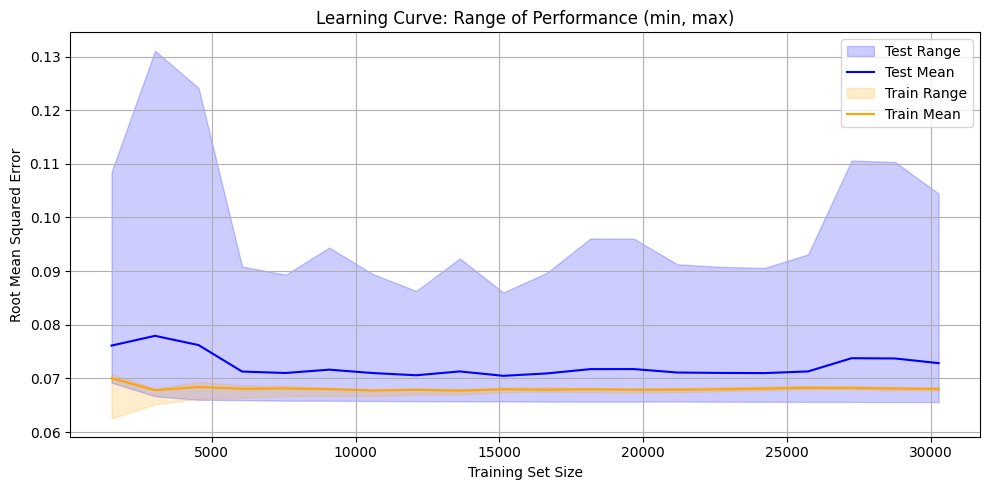

In [17]:
f_learn, ax = plt.subplots(figsize=(10, 5))

# Plot test scores
ax.fill_between(train_sizes, 
                np.sqrt(-test_scores.min(axis=1)), 
                np.sqrt(-test_scores.max(axis=1)), 
                alpha=0.2, 
                label='Test Range', 
                color='blue')
ax.plot(train_sizes, 
        np.sqrt(-test_scores.mean(axis=1)), 
        color='blue', 
        label='Test Mean')

# Plot train scores
ax.fill_between(train_sizes, 
                np.sqrt(-train_scores.min(axis=1)), 
                np.sqrt(-train_scores.max(axis=1)), 
                alpha=0.2, 
                label='Train Range', 
                color='orange')
ax.plot(train_sizes, 
        np.sqrt(-train_scores.mean(axis=1)), 
        color='orange', 
        label='Train Mean')

ax.set_title('Learning Curve: Range of Performance (min, max)')
ax.set_xlabel('Training Set Size')
ax.set_ylabel('Root Mean Squared Error')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

In [18]:
train_sizes

array([ 1513,  3027,  4540,  6054,  7567,  9081, 10594, 12108, 13621,
       15135, 16648, 18162, 19675, 21189, 22702, 24216, 25729, 27243,
       28756, 30270])

## Validation Curve - Lasso Regression

In [19]:
train_scores, test_scores = validation_curve(
    estimator=pipe_lasso,
    X=X_train_selected,
    y=y_train,
    param_name='lasso__alpha',
    param_range=lambdas,
    scoring='neg_mean_squared_error',
    cv=10
)

In [20]:

mse_score = pd.DataFrame({
    'Train': -train_scores.mean(axis=1),
    'Validation': -test_scores.mean(axis=1),
    'lambda': lambdas
}).set_index('lambda')

optimal_lambda = mse_score.Validation.nsmallest(1)
print("Optimal lambda and its corresponding validation MSE:")
print(optimal_lambda)


Optimal lambda and its corresponding validation MSE:
lambda
0.002848    0.004917
Name: Validation, dtype: float64


<Figure size 1000x600 with 0 Axes>

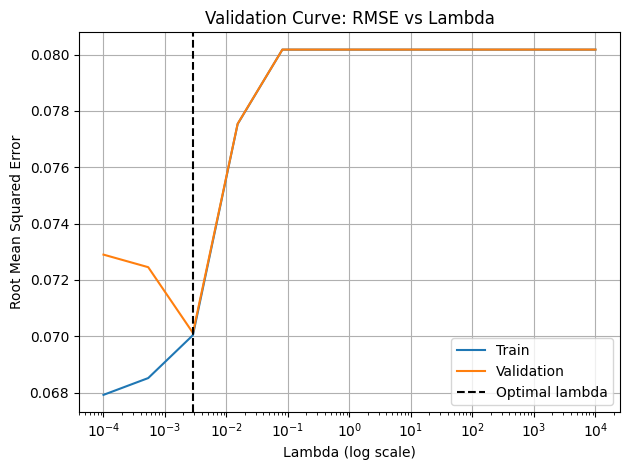

In [21]:

plt.figure(figsize=(10, 6))
np.sqrt(mse_score).plot(logx=True)
plt.axvline(x=optimal_lambda.index[0], color='black', linestyle='--', label='Optimal lambda')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Root Mean Squared Error')
plt.title('Validation Curve: RMSE vs Lambda')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Our Final model

In [22]:
lasso_model = Lasso(alpha=0.00015) 
lasso_model.fit(X_train_selected, y_train)

y_pred_log = lasso_model.predict(X_test_selected)

mse_log = mean_squared_error(y_test, y_pred_log)
print(f"MSE: {mse_log.round(5)}")

lasso_coef= pd.Series(lasso_model.coef_, index= X.columns[significant_indices])
lasso_coef

MSE: 0.00502


rooms                       -0.003999
size                        -0.011618
buildYear                    0.012209
year                         0.010300
area_of_sports_facilities   -0.003821
descendants                  0.015232
average_age                  0.026024
immigrants                  -0.005990
municipal_tax               -0.014626
primaryschool               -0.022403
kvu                         -0.015258
lvu                          0.008557
job                         -0.008187
dtype: float64

## Ridge regression

In [23]:

X = data.drop(['propertyType','sqmPrice', 'municipalityCode', 'estateId', 'address', 'zipCode', 'price', 'soldDate', 'ouId', 'ouAddress', 'change', 'Municipality', 'population','danish_origin'], axis=1)
y = data['sqmPrice']
X_train, X_test, y_train, y_test = split_data(X, y)

In [24]:
ridge_model = Ridge(alpha=0.00015)
ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)

mse_log = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse_log:.5f}")

ridge_coef = pd.Series(ridge_model.coef_, index=X.columns)
print(ridge_coef)

MSE: 0.00501
rooms                       -0.004164
size                        -0.011685
buildYear                    0.012402
year                         0.014457
area_of_sports_facilities   -0.005248
descendants                  0.019241
crimes                      -0.000968
full_time_unemployed        -0.000944
gini_coefficient            -0.000283
average_age                  0.022452
immigrants                  -0.010846
municipal_tax               -0.016388
primaryschool               -0.028811
kvu                         -0.027549
lvu                          0.008344
job                         -0.009197
distance_from_centre        -0.000842
dtype: float64


## Removing insignificant variables

In [25]:
significant_indices = np.where(np.abs(ridge_coef) >1e-3)[0]
X_train_selected = X_train[:, significant_indices]
X_test_selected = X_test[:, significant_indices]

In [26]:
ridge_reduced_model = Ridge(alpha=0.001)
ridge_reduced_model.fit(X_train_selected, y_train)
y_pred_log = ridge_reduced_model.predict(X_test_selected)
mse_log = mean_squared_error(y_test, y_pred_log)

print(f"MSE: {mse_log.round(5)}")
lasso_coef3= pd.Series(ridge_reduced_model.coef_, index= X.columns[significant_indices])
lasso_coef3

MSE: 0.00501


rooms                       -0.004165
size                        -0.011706
buildYear                    0.012391
year                         0.015388
area_of_sports_facilities   -0.005626
descendants                  0.018471
average_age                  0.022405
immigrants                  -0.010676
municipal_tax               -0.016428
primaryschool               -0.029152
kvu                         -0.027209
lvu                          0.008526
job                         -0.009681
dtype: float64

## Validation - Ridge 

In [27]:
degree_range = range(5)  # 0 to 4
lambdas = np.logspace(-4, 4, 12)

results = []

for degree in degree_range:
    pipelines = [
        make_pipeline(
            PolynomialFeatures(degree=degree),
            StandardScaler(),
            Ridge(alpha=lambda_, random_state=99999, max_iter=2000, tol=0.01)
        )
        for lambda_ in lambdas
    ]
    
    mse_scores = [
        mean_squared_error(y_test, pipe.fit(X_train_selected, y_train).predict(X_test_selected))
        for pipe in pipelines
    ]
    
    best_idx = np.argmin(mse_scores)
    optimal_lambda = lambdas[best_idx]
    optimal_mse = mse_scores[best_idx]
    
    results.append((degree, optimal_lambda, optimal_mse))
    print(f"Degree: {degree}, Optimal lambda: {optimal_lambda:.4f}, Validation MSE: {optimal_mse:.4f}")

# Extract MSE results for plotting
mse_results_ridge = [result[2] for result in results]


Degree: 0, Optimal lambda: 0.0001, Validation MSE: 0.0066
Degree: 1, Optimal lambda: 0.0001, Validation MSE: 0.0050
Degree: 2, Optimal lambda: 2.3101, Validation MSE: 0.0046
Degree: 3, Optimal lambda: 65.7933, Validation MSE: 0.0045
Degree: 4, Optimal lambda: 351.1192, Validation MSE: 0.0045


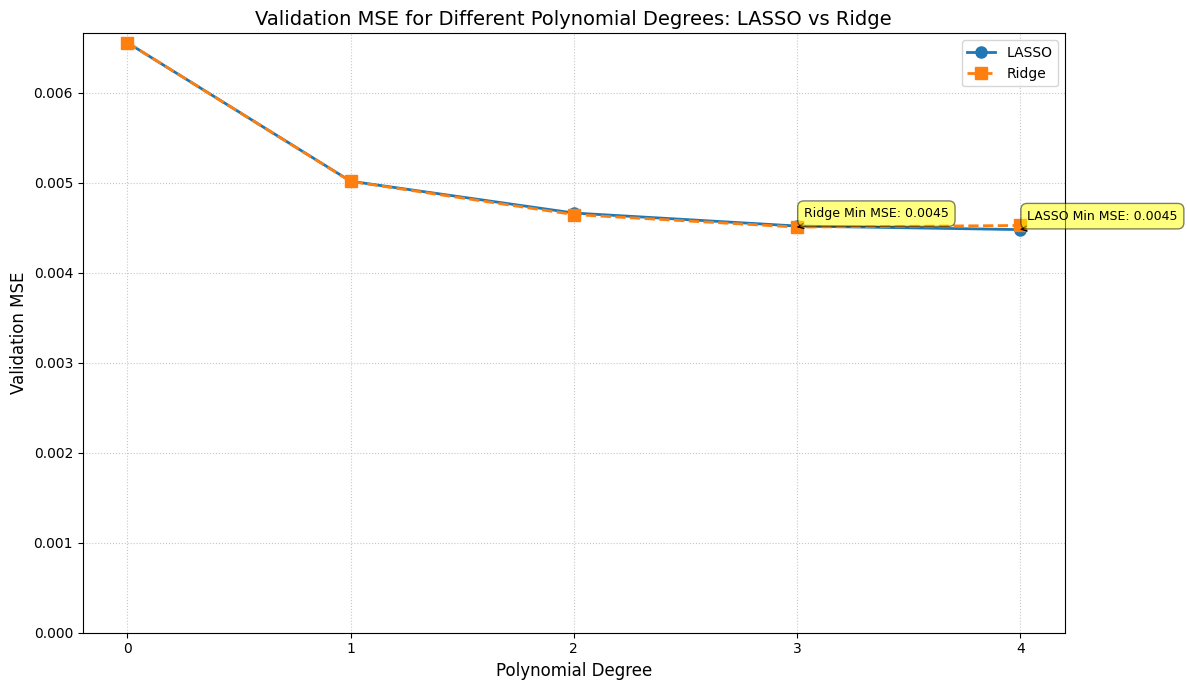

In [28]:
plt.figure(figsize=(12, 7))

plt.plot(degree_range, mse_results, marker='o', linestyle='-', linewidth=2, markersize=8, label='LASSO')
plt.plot(degree_range, mse_results_ridge, marker='s', linestyle='--', linewidth=2, markersize=8, label='Ridge')

plt.xlabel('Polynomial Degree', fontsize=12)
plt.ylabel('Validation MSE', fontsize=12)
plt.title('Validation MSE for Different Polynomial Degrees: LASSO vs Ridge', fontsize=14)
plt.xticks(degree_range)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.7)

plt.ylim(bottom=0)  # Start y-axis from 0

# Annotate the minimum MSE points
for results, name in zip([mse_results, mse_results_ridge], ['LASSO', 'Ridge']):
    min_mse_idx = min(range(len(results)), key=results.__getitem__)
    min_mse = results[min_mse_idx]
    plt.annotate(f'{name} Min MSE: {min_mse:.4f}', 
                 xy=(degree_range[min_mse_idx], min_mse), 
                 xytext=(5, 5), 
                 textcoords='offset points', 
                 ha='left', 
                 va='bottom',
                 fontsize=9,
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.show()

In [29]:
print("LASSO MSE results",mse_results)
print("RIDGE MSE results", mse_results_ridge)

LASSO MSE results [0.006554828918479611, 0.005015681416751759, 0.004662656625909847, 0.004517913808854147, 0.004478251459903367]
RIDGE MSE results [0.006554828918479611, 0.005013271472614661, 0.004645110867539438, 0.004506087883869465, 0.00452418158824094]


In [30]:
pipe_ridge = make_pipeline(
            PolynomialFeatures(degree=2),
            StandardScaler(),
            Ridge(alpha=0.0001, random_state=99999, max_iter=2000, tol=0.01)
        )

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_ridge,
                   X= X_train_selected,  #X_dev,
                   y= y_train,
                   train_sizes=np.arange(0.05, 1.05, .05),
                   scoring='neg_mean_squared_error',                 
                   cv=8)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))

mse_.head(5)

,Train,Test
sample size,,
1471,0.004692,0.006715
2942,0.004467,0.006326
4414,0.004601,0.006150
5885,0.004576,0.005599
7357,0.004570,0.005806


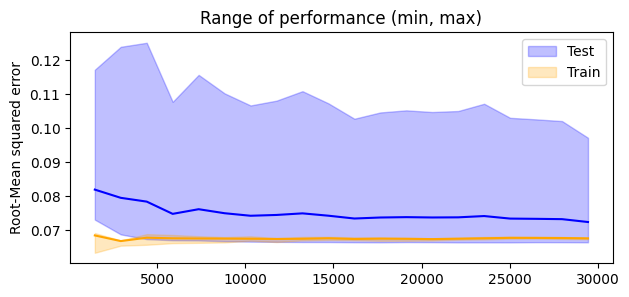

In [31]:
f_learn, ax = plt.subplots(figsize=(7,3))
ax.fill_between(train_sizes, np.sqrt(-test_scores.min(1)), np.sqrt(-test_scores.max(1)), alpha=0.25, label ='Test', color = 'blue')#, color='blue')
ax.fill_between(train_sizes, np.sqrt(-train_scores.min(1)), np.sqrt(-train_scores.max(1)),  alpha=0.25, label='Train', color = 'orange' )#, color='orange')

ax.plot(train_sizes,np.sqrt(-test_scores.mean(1)), color='blue') # label ='Test' 
ax.plot(train_sizes,np.sqrt(-train_scores.mean(1)), color='orange') #  label='Train' 

ax.set_title('Range of performance (min, max)')
ax.set_ylabel('Root-Mean squared error')
ax.legend()
plt.show()

In [32]:
train_sizes

array([ 1471,  2942,  4414,  5885,  7357,  8828, 10300, 11771, 13243,
       14714, 16185, 17657, 19128, 20600, 22071, 23543, 25014, 26486,
       27957, 29429])

# ElasticNet

In [33]:
# Assuming X_train_selected, X_test_selected, y_train, y_test are already defined
def create_and_fit_model(model_class, param_grid, X_train, y_train):
    pipe = make_pipeline(
        PolynomialFeatures(degree=2),
        StandardScaler(),
        model_class(random_state=80499, max_iter=2000)
    )
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

# ElasticNet
elasticnet_param_grid = {
    'elasticnet__alpha': np.logspace(-4, 1, 20),
    'elasticnet__l1_ratio': np.linspace(0.1, 1.0, 10)
}
best_elasticnet = create_and_fit_model(ElasticNet, elasticnet_param_grid, X_train, y_train)

# Lasso
lasso_param_grid = {
    'lasso__alpha': np.logspace(-4, 1, 20)
}
best_lasso = create_and_fit_model(Lasso, lasso_param_grid, X_train, y_train)

# Ridge
ridge_param_grid = {
    'ridge__alpha': np.logspace(-4, 1, 20)
}
best_ridge = create_and_fit_model(Ridge, ridge_param_grid, X_train, y_train)

/home/thor/.conda/envs/household/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.873e+00, tolerance: 1.725e-02
  model = cd_fast.enet_coordinate_descent(
/home/thor/.conda/envs/household/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.086e+00, tolerance: 1.734e-02
  model = cd_fast.enet_coordinate_descent(
/home/thor/.conda/envs/household/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

In [34]:
models = {
    'ElasticNet': best_elasticnet,
    'Lasso': best_lasso,
    'Ridge': best_ridge
}

results = []
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mse = -cv_scores.mean()
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    results.append({'Model': name, 'MSE': mse, 'R2': r2})

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)


Model Comparison:
        Model       MSE        R2
0  ElasticNet  0.004845  0.252464
1       Lasso  0.004853  0.256170
2       Ridge  0.005410  0.298034


## Comparissons in the graphs

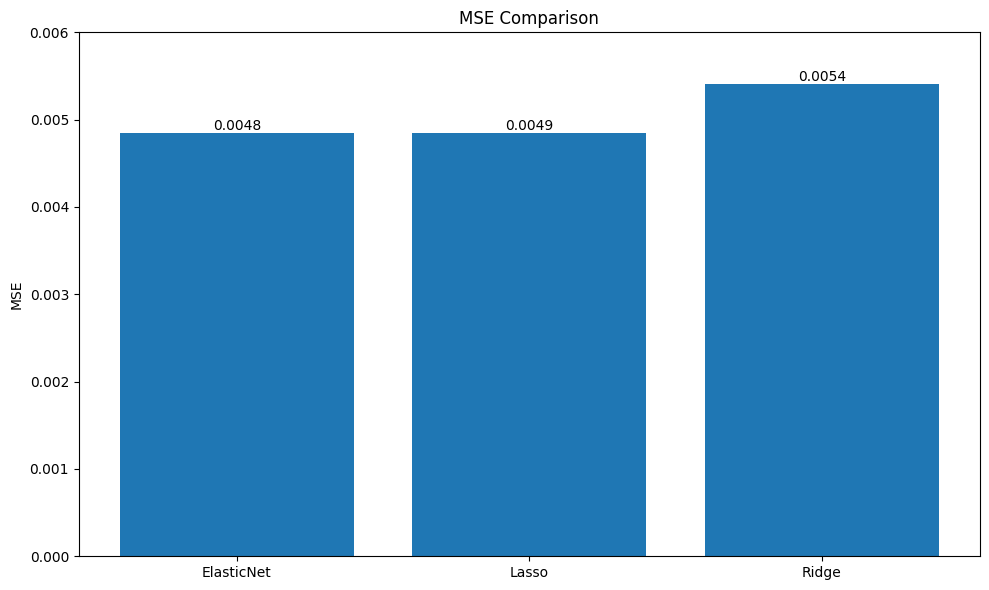

In [35]:
# Visualize comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['MSE'])
plt.title('MSE Comparison')
plt.ylabel('MSE')
plt.ylim(0, 0.006)  # Assuming R2 is between 0 and 1
for i, v in enumerate(results_df['MSE']):
    plt.text(i, v, f'{v:.4f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

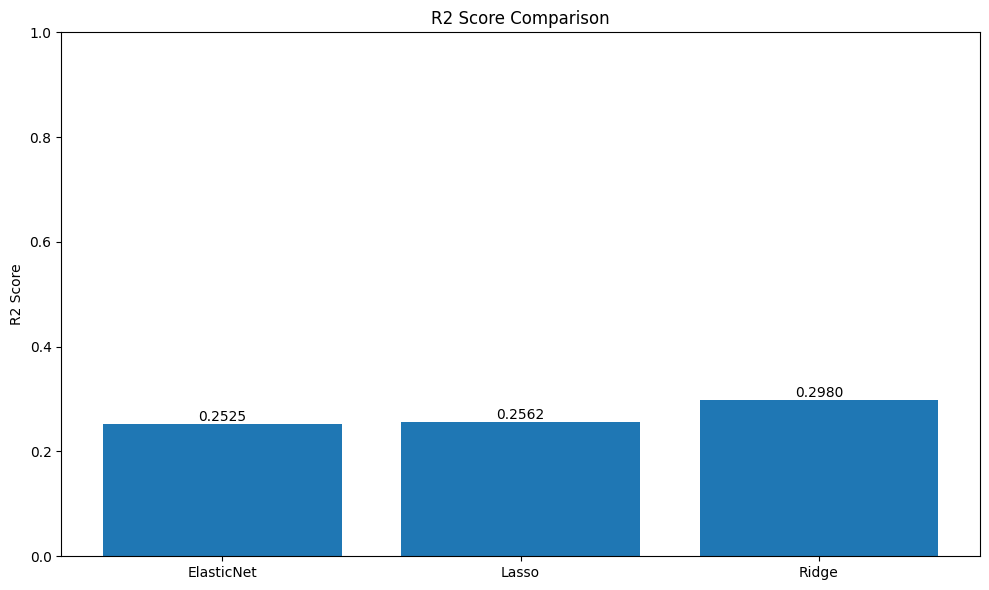

In [36]:
# Visualize comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['R2'])
plt.title('R2 Score Comparison')
plt.ylabel('R2 Score')
plt.ylim(0, 1)  # Assuming R2 is between 0 and 1
for i, v in enumerate(results_df['R2']):
    plt.text(i, v, f'{v:.4f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()